In [1]:
import sys
sys.path.append("../")

import numpy as np
import math as m
from scipy.optimize import minimize
import sys
import platform
import os
import pandas as pd
import numpy as np
import emcee
import corner
import matplotlib.pyplot as plt
import camb
import pandas as pd

# Import pyACC logger
from pyACC.helpers import Logger

# Set the logger
print = Logger("pyACC.CosmologicalDistances")

# Import integration class
from pyACC.Cosmology.distances import Dc, Dc_w0wa, Dc_w

In [2]:
# READ THE DATA
# Load the data
file_path = 'binned_data.txt'

# Read the first line to get the header
with open(file_path, 'r') as file:
    header_line = file.readline().strip()
    header = header_line.lstrip('#').strip()

# Remove the last word from the header (assumed to be 'biascor')
header_words = header.split()
header_words.pop()
header = ' '.join(header_words)

# Read the rest of the file into a DataFrame
data = pd.read_csv(file_path, sep='\s+', skiprows=1, header=None)
data.columns = header.split()

In [3]:
# Definition of the Hubble function and set the cosmology
def hubble_function_w0wa(z, Omega_m, Omega_r, Omega_k, Omega_lambda, w0, wa, H0):
    # Calculate the dark energy contribution
    dark_energy_contribution = (1 + z)**(3 * (1 + w0 + wa)) * np.exp(-3 * wa * z / (1 + z))
    
    # Calculate H(z)
    Hz = H0 * np.sqrt(
        Omega_m * (1 + z)**3 +
        Omega_r * (1 + z)**4 +
        Omega_k * (1 + z)**2 +
        Omega_lambda * dark_energy_contribution
    )
    
    return Hz

In [4]:
# Extract relevant columns
d = data['mb'].values
dmb = data['dmb'].values

# Compute the covariance matrix
Sigma = np.diag(dmb**2)
Sigma_inv = np.linalg.inv(Sigma)

#print(data.head())
print("Covariance Matrix (Sigma):")
print(Sigma)
print("Inverse Covariance Matrix (Sigma_inv):")
print(Sigma_inv)

def ln_likelihood(params, data, cov_inv):
    Omega_mat, w0, wa = params #I don't put H0 because depends on the M (absolute magnitude) , Omega_rad, Omega_k, Omega_L
    H0 = 68.
    #print(Omega_mat, Omega_rad, Omega_k, Omega_L, w0, wa)
    # Check if the parameters are within the physical range
    if Omega_mat < 0: #or Omega_rad or Omega_k or Omega_L
        #print("Negative parameter")
        return -np.inf
    #else:
        #print("Positive parameter")
    if w0 < -3 or w0 > 3:
        print("w0 out of range")
        return -np.inf
    if wa < -3 or wa > 3:
        print("wa out of range")
        return -np.inf
    z = data['zcmb'].values
    d = data['mb'].values 
    mu = []
    for z_prime in z:
        mu.append(5*np.log10(Dc_w0wa(hubble_function_w0wa, z_prime, Omega_mat, 0., 0., 0.7, w0, wa, H0)*(1+z_prime)) + 25) #it is equivalent to get_mu(z, H0, Om0, w0, wa)
    diff = d - mu
    term1 = -0.5 * diff @ cov_inv @ diff # @ is the matrix multiplication
    term2 = 0.5 * ((np.ones_like(diff) @ cov_inv @ diff) ** 2) / (np.ones_like(diff) @ cov_inv @ np.ones_like(diff))
    #print(term1, term2, term1+term2)
    return term1 + term2

def log_prior(params):
    Omega_mat, w0, wa = params #, Omega_rad, Omega_k, Omega_L,
    if not (0.1 < Omega_mat < 0.5):
        return -np.inf
    '''
    if not (0. < Omega_rad < 0.01):
        return -np.inf
    if not (0. < Omega_k < 0.001):
        return -np.inf
    if not (0.3 < Omega_L < 0.9):
        return -np.inf
    '''
    if not (-3. < w0 < 3.):
        return -np.inf
    if not (-3. < wa < 3.):
        return -np.inf
    
    return 0.0

def log_posterior(params, data, cov_inv):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + ln_likelihood(params, data, cov_inv)

# Initialize the MCMC sampler
initial = np.array([0.3, -1., 0]) #, 0.00005, 0., 0.7
ndim = len(initial)
nwalkers = 500
pos = initial + 1e-4 * np.random.randn(nwalkers, ndim) # provare con 1e-1

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(data, Sigma_inv))

# Run the MCMC sampler
nsteps = 2000
sampler.run_mcmc(pos, nsteps, progress=True)

# Get the samples
samples = sampler.get_chain(discard=300, thin=10, flat=True)



2024-07-26 17:17:39.773689 :: pyACC.CosmologicalDistances  :: Covariance Matrix (Sigma):
2024-07-26 17:17:39.773841 :: pyACC.CosmologicalDistances  :: [[0.00096721 0.         0.         ... 0.         0.         0.        ]
 [0.         0.0006996  0.         ... 0.         0.         0.        ]
 [0.         0.         0.00053361 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.00076176 0.         0.        ]
 [0.         0.         0.         ... 0.         0.00317532 0.        ]
 [0.         0.         0.         ... 0.         0.         0.00540225]]
2024-07-26 17:17:39.774698 :: pyACC.CosmologicalDistances  :: Inverse Covariance Matrix (Sigma_inv):
2024-07-26 17:17:39.774780 :: pyACC.CosmologicalDistances  :: [[1033.9016346     0.            0.         ...    0.
     0.            0.        ]
 [   0.         1429.38311398    0.         ...    0.
     0.            0.        ]
 [   0.            0.         1874.02784805 ...    0.
     0.           

  0%|          | 1/2000 [01:19<44:23:16, 79.94s/it]Traceback (most recent call last):
  File "/home/andrewcats/anaconda3/envs/acc-env/lib/python3.9/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/tmp/ipykernel_12540/1605132124.py", line 65, in log_posterior
    return lp + ln_likelihood(params, data, cov_inv)
  File "/tmp/ipykernel_12540/1605132124.py", line 35, in ln_likelihood
    mu.append(5*np.log10(Dc_w0wa(hubble_function_w0wa, z_prime, Omega_mat, 0., 0., 0.7, w0, wa, H0)*(1+z_prime)) + 25) #it is equivalent to get_mu(z, H0, Om0, w0, wa)
  File "/home/andrewcats/AstroCosmoComputational/Students/AndreaGatti/Exam_Computazza/../pyACC/Cosmology/distances.py", line 26, in Dc_w0wa
    return trapezi(lambda z : funz_w0wa(z,H,omega_mat,omega_rad,omega_k,omega_lambda,w0,wa,H0), 0, z, 1000)
  File "/home/andrewcats/AstroCosmoComputational/Students/AndreaGatti/Exam_Computazza/../pyACC/Calculus/integrate.py", line 22, in trapezi

emcee: Exception while calling your likelihood function:
  params: [ 2.99941445e-01 -9.99852482e-01  9.62766259e-05]
  args: (    name    zcmb    zhel   dz         mb      dmb  x1  dx1  color  dcolor  \
0      0  0.0140  0.0140  0.0  14.570019  0.03110   0    0      0       0   
1      1  0.0194  0.0194  0.0  15.227960  0.02645   0    0      0       0   
2      2  0.0264  0.0264  0.0  15.934102  0.02310   0    0      0       0   
3      3  0.0329  0.0329  0.0  16.421783  0.02350   0    0      0       0   
4      4  0.0396  0.0396  0.0  16.836419  0.02845   0    0      0       0   
5      5  0.0475  0.0475  0.0  17.234644  0.03340   0    0      0       0   
6      6  0.0560  0.0560  0.0  17.575846  0.03215   0    0      0       0   
7      7  0.0640  0.0640  0.0  17.910454  0.04390   0    0      0       0   
8      8  0.0721  0.0721  0.0  18.178007  0.03865   0    0      0       0   
9      9  0.0811  0.0811  0.0  18.554386  0.04225   0    0      0       0   
10    10  0.0889  0.0889  0

KeyboardInterrupt: 

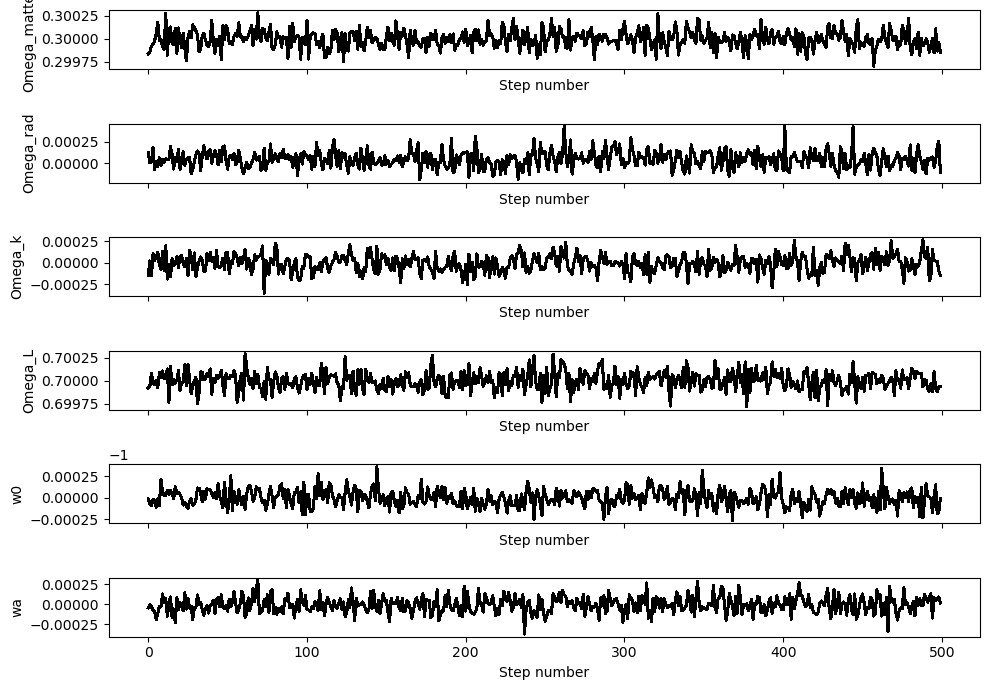

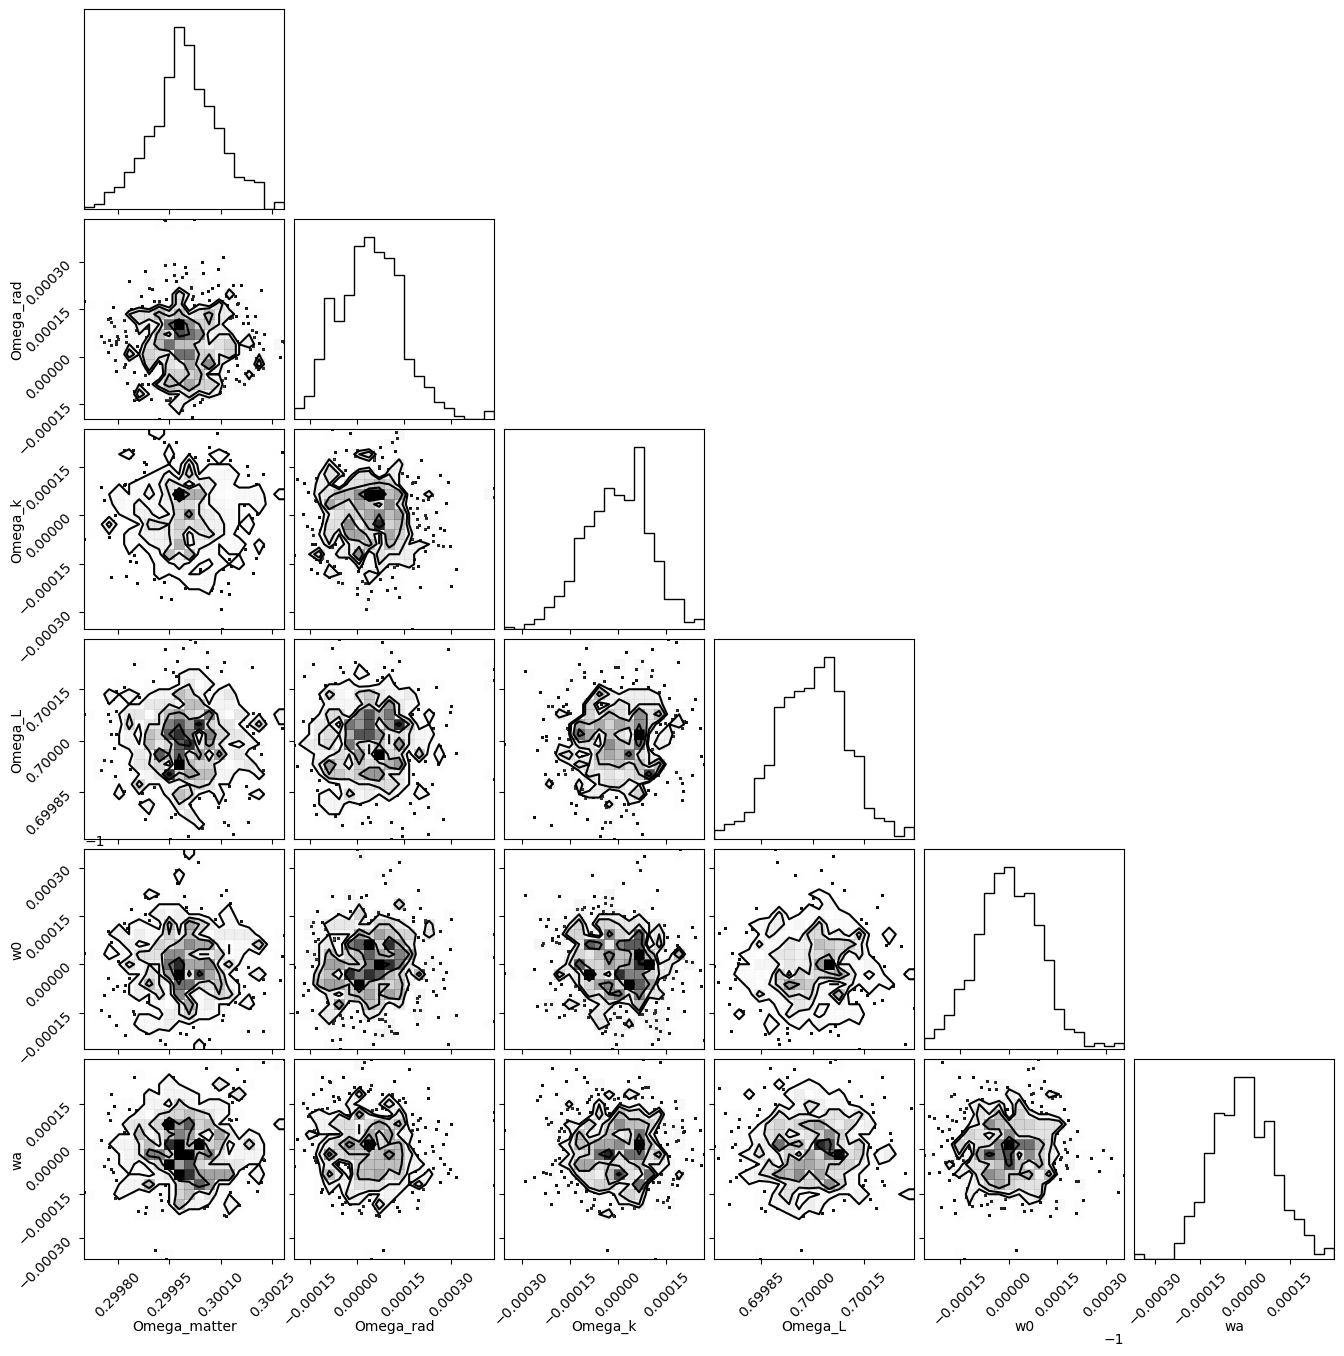

In [ ]:
# Plot the chains for each parameter
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
labels = ["Omega_matter", "Omega_rad", "Omega_k", "Omega_L", "w0", "wa"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(sampler.chain[:, :, i], color="k", alpha=0.3)
    ax.set_ylabel(labels[i])
    ax.set_xlabel("Step number")

plt.tight_layout()
plt.show()

# Plot the results
fig = corner.corner(samples, labels=labels)
